In [ ]:
# Method 1: Using numpy
import numpy as np
a = np.array(x)
b = np.array(y)
dist = np.linalg.norm(a-b)

# Method 2: Using scipy
from scipy.spatial import distance
dst = distance.euclidean(a,b)

# numpy is faster than scipy

In [283]:
import pandas as pd
import numpy as np
data = pd.read_excel('HealthViz County Dataset 6.19.17.xlsx',skiprows=0, header=1, index_col=0)
data.index.name=None
data.drop(data.columns[[0,1]], axis=1, inplace=True)

In [284]:
df = pd.read_csv('HealthViz County Dataset 6 21 17.csv', skiprows=0, header=1, index_col=0, encoding = "ISO-8859-1")
df.index.name=None

In [285]:
large_population = df['Population (residents), 2011-2015'] >= 150000

In [286]:
df = df[large_population]

In [287]:
df.shape

(428, 18)

In [293]:
df = df.ix[:,8:]

/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [294]:
df.dropna(axis=0, how='any', inplace=True)

In [295]:
# Step 1: Normalize/whiten the dataframe, determine the target place (represented in GEOID, int)
# Step 2: Get the Euclidean distance of values betweem each place and the target one for each row in dataframe
# Step 3: Sort the dataframe based on the arising order of the distance
# Step 4: Get the list of top N similar places

from scipy.cluster.vq import kmeans,vq,whiten

# Used only for this case, assuming the dataframe passed to the distance/clustering has no null values
def drop_null(df):
    '''
    Drop the columns and rows with any null value
    '''
    
    #df.dropna(axis=1, how='any', inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df
    
    
def normalize_df(df):
    '''
    Normalize/whiten the dataframe
    '''
    df = pd.DataFrame(whiten(df), columns=df.columns, index=df.index)
    return df

def get_distance(df, GEOID_target, GEOID):
    '''
    Get the Euclidean distance between two sets of values
        GEOID_target, GEOID: index, int
    '''
    a = df.loc[[GEOID_target]].values # df.values
    b = df.loc[[GEOID]].values
    dist = np.linalg.norm(a-b)
    return dist

def  get_top_n_similar(data, GEOID_target, n):
    '''
    Get the N places which are similar to the target place
        data: dataframe
        GEOID_target: index, int
        n: int
    '''
    df = drop_null(data)
    df = normalize_df(df)
    df['distance'] = df.apply(lambda x: get_distance(df, GEOID_target, x.name), axis=1)
    df = df.sort_values('distance', ascending=True)
    index_list = df.head(n+1).index.tolist()[1:]
    return index_list
    

In [296]:
get_top_n_similar(df, 1003, 3)

[22103, 12113, 6097]

In [297]:
# elbow effect to choose K in K-means
# sum of squared error (SSE): sum of the squared distance between each member of the cluster and its centroid

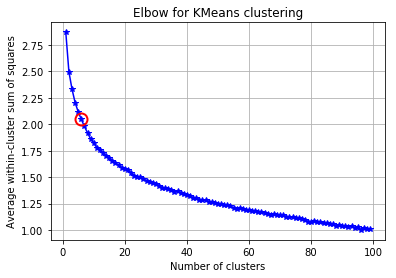

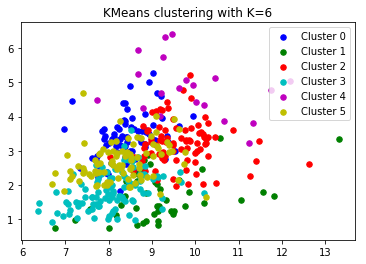

In [301]:
from scipy.cluster.vq import kmeans,vq,whiten
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

K = range(1,100)
X = whiten(df)
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

kIdx = 5
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X[ind,2],X[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
#plt.xlabel('Petal Length')
#plt.ylabel('Sepal Width')
plt.title('KMeans clustering with K=%d' % K[kIdx])
plt.legend()

plt.show()



In [312]:
avgWithinSS
l = []
for i in range(1,99):
    rate = abs(avgWithinSS[i] - avgWithinSS[i-1])/avgWithinSS[i]
    l = l + [rate]